#### Installs / Imports / Functions

In [1]:
%%capture
!pip install anndata
!pip install tensorflow
!pip install scikit-learn

import logging
import argparse
import warnings
warnings.filterwarnings("ignore")

import os
import time
import anndata
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras import layers
from keras import backend as K

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm



class VAE(keras.Model):
    def __init__(self, opt, x_train, x_test, batch_size, original_dim, hidden_layer, latent_dim, epochs):
        super(VAE, self).__init__()
        inputs = keras.Input(shape=(original_dim,))
        h = layers.Dense(hidden_layer, activation='relu')(inputs)
        
        z_mean = layers.Dense(latent_dim)(h)
        z_log_sigma = layers.Dense(latent_dim)(h)

        # Sampling
        def sampling(args):
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                    mean=0., stddev=0.1)
            return z_mean + K.exp(z_log_sigma) * epsilon

        z = layers.Lambda(sampling)([z_mean, z_log_sigma])

        # Create encoder
        encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
        self.encoder = encoder
        # Create decoder
        latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
        x = layers.Dense(hidden_layer, activation='relu')(latent_inputs) #relu

        outputs = layers.Dense(original_dim, activation='sigmoid')(x)    
        decoder = keras.Model(latent_inputs, outputs, name='decoder')
        self.decoder = decoder
        
        # instantiate VAE model
        outputs = decoder(encoder(inputs)[2])
        vae = keras.Model(inputs, outputs, name='vae_mlp')
        
        # loss
        reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
        reconstruction_loss *= original_dim        
        kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5   
        vae_loss = K.mean(0.9*(reconstruction_loss) + 0.1*(kl_loss))
        vae.add_loss(vae_loss)
        
        vae.compile(optimizer= opt, loss='mean_squared_error', metrics=['accuracy'])
        vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, x_test))

def cook(data,
	log2_normalization = True,
	hidden_layer = None,
        latent_dim = None,
        epochs = 50,
        batch_size = 32,
        ):
    
    if type(data)==anndata._core.anndata.AnnData:
        x = data.X.T
        row_names = data.var.index
    else:
        x = np.asarray(data, dtype=np.float32)
        row_names = data.index
    
    if np.any(x < 0):
        log2_normalization = False
        logging.warn(" Negative values are detected or log2_normalization was set to False, so log2 normalization is not applied.")
    
    if log2_normalization == True:
        x = np.log2(1+x[:])
        logging.warn(" log2 normalization is applied.")

    x = x / np.max(x, axis=1, keepdims=True)
    x = np.nan_to_num(x)
    
    original_dim = x.shape[1]
    if hidden_layer==None:
        if original_dim >= 2000:
            hidden_layer = 1000
        if original_dim > 500 and original_dim < 2000:
            hidden_layer = 500
        if original_dim <= 500:
            hidden_layer = 50

    if latent_dim==None:
        if hidden_layer >= 1000:
            latent_dim = 100
        if hidden_layer >= 500 and hidden_layer < 1000:
            latent_dim = 50
        if hidden_layer <= 500:
            latent_dim = 5

    opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=0.001)
    x_train = x_test = np.array(x) 
    vae = VAE(opt, x_train, x_test, batch_size, original_dim, hidden_layer, latent_dim, epochs)
    x_test_encoded = np.array(vae.encoder.predict(x_test, batch_size=batch_size))
    return x_test_encoded


def Latent_Space(x_test_encoded):
    # Concatenate latent spaces
    df_x_test_encoded_0 = pd.DataFrame(x_test_encoded[0,:,:])
    df_x_test_encoded_1 = pd.DataFrame(x_test_encoded[1,:,:])
    df_x_test_encoded_2 = pd.DataFrame(x_test_encoded[2,:,:])

    df_x_test_encoded_01 = pd.merge(df_x_test_encoded_0, df_x_test_encoded_1, left_index=True, right_index=True)
    df_x_test_encoded = pd.merge(df_x_test_encoded_01, df_x_test_encoded_2, left_index=True, right_index=True)
    return df_x_test_encoded_2



def train_test_dev(X, y, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1):
    T = X[0]
    X_train, X_test, y_train, y_test = train_test_split(T, y, test_size=1 - train_ratio)

    if validation_ratio != 0:
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio))
    else:
        X_val, y_val = None, None

    dfs_train = {}
    dfs_test = {}
    dfs_val = {}

    for i in range(0, len(X)):
        df_i = X[i]
        name = f'df{i}'  # Generate the name based on the value of i

        X_train_i = pd.merge(X_train.drop(X_train.columns, axis=1), df_i, left_index=True, right_index=True)
        X_test_i = pd.merge(X_test.drop(X_train.columns, axis=1), df_i, left_index=True, right_index=True)
        X_val_i = pd.merge(X_val.drop(X_train.columns, axis=1), df_i, left_index=True, right_index=True)

        dfs_train[name] = X_train_i
        dfs_test[name] = X_test_i
        dfs_val[name] = X_val_i

    return dfs_train, dfs_test, dfs_val, y_train, y_test, y_val


def SVM(X_train, y_train):
    svm_classifier = svm.SVC(probability=True)
    cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    print("Mean Cross-Validated Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

    y_pred_probs = cross_val_predict(svm_classifier, X_train, y_train, cv=5, method='predict_proba')
    y_pred = cross_val_predict(svm_classifier, X_train, y_train, cv=5)
    
    
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(svm_classifier, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(svm_classifier, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return svm_classifier, fpr, tpr, roc_auc, mean_score, std_score

def RF(X_train, y_train):

    # Create RandomForestClassifier instance
    rf_classifier = RandomForestClassifier()

    # Perform 5-fold cross-validation and compute mean accuracy
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()  # Calculate the standard deviation of the scores

    print("Mean Cross-Validated Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

    y_pred_probs = cross_val_predict(rf_classifier, X_train, y_train, cv=5, method='predict_proba')
    
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(rf_classifier, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(rf_classifier, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return rf_classifier, fpr, tpr, roc_auc,mean_score, std_score


def logistic_regression(X_train, y_train):
   
    # Create logistic regression model instance
    logistic_reg = LogisticRegression()
    
    # Perform 5-fold cross-validation and compute mean accuracy
    cv_scores = cross_val_score(logistic_reg, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    
    print("Mean Cross-Validated Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)
    
    y_pred_probs = cross_val_predict(logistic_reg, X_train, y_train, cv=5, method='predict_proba')
    
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(logistic_reg, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(logistic_reg, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return logistic_reg, fpr, tpr, roc_auc, mean_score, std_score


def Classifier(Classifier, X_val,y_val, Model = "SVM"):
    X_test = X_val
    y_test = y_val   
    if Model == "SVM":
        y_pred = Classifier.predict(X_test)
        y_pred_proba = Classifier.decision_function(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC:", auc)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return

#### Read Data and create Normalized datasets
1. Log normalized
2. Row wise normalized (divide row wise sum)
3. Rank (Row wise then ranked per column)

In [1]:
import pandas as pd

index = pd.read_csv("Adipose.tsv", sep='\t', index_col=0,usecols=range(0, 10))
data

,Genes,Adipose,Adipose.1,Adipose.2,Adipose.3,Adipose.4,Adipose.5,Adipose.6,Adipose.7,Adipose.8,...,Adipose.80072,Adipose.80073,Adipose.80074,Adipose.80075,Adipose.80076,Adipose.80077,Adipose.80078,Adipose.80079,Adipose.80080,Adipose.80081
ENSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,2,0,1,0,0,1,1,0,0,...,0,1,1,1,0,1,2,1,1,0
ENSG00000000457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ENSG00000000460,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000288678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000288681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000288684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df = data.sample(n=40000,axis='columns')

In [9]:
df = data.sample(n=40000,axis='columns')
df.to_csv('Adipose_40k.tsv', index=True)

df = data.sample(n=40000,axis='columns')

In [2]:
data = pd.read_csv("jonas_100k_genes.tsv", usecols=range(0, 50001), sep=' ', index_col=0)
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
for column in non_numeric_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
data

,Brain,Adipose,Brain.1,Endometrium,Endometrium.1,Endometrium.2,Kidney,Skin,Brain.2,Skeletal,...,Adipose.7355,Prostate.3200,Skin.1357,Lymph.685,Endometrium.6203,Testis.619,Eye.1765,Ovary.3833,Brain.6698,Prostate.3201
Genes,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,7,1.0,0,0,0,0.0,0,0.0,0,...,0.0,0,1,0,15,0,0,0,0,8.0
ENSG00000000005,0.0,0,0.0,0,0,0,0.0,0,0.0,0,...,0.0,0,0,0,0,0,0,0,0,0.0
ENSG00000000419,0.0,0,0.0,1,0,1,0.0,0,0.0,0,...,0.0,0,0,2,0,0,2,0,0,0.0
ENSG00000000457,0.0,0,0.0,0,0,0,0.0,0,0.0,0,...,0.0,0,0,0,1,0,0,0,0,2.0
ENSG00000000460,0.0,0,0.0,0,0,0,0.0,0,0.0,0,...,0.0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288677,0.0,0,0.0,0,0,0,0.0,0,0.0,0,...,0.0,0,0,0,0,0,0,0,0,0.0
ENSG00000288678,0.0,0,0.0,0,0,0,0.0,0,0.0,0,...,0.0,0,0,0,0,0,0,0,0,0.0
ENSG00000288681,0.0,0,0.0,0,0,0,0.0,0,0.0,0,...,0.0,0,0,0,0,0,0,0,0,0.0


In [3]:
data_log = data.applymap(lambda x: np.log2(1 + x))
data_log.to_csv('data_log_50k.csv', index=True)

In [3]:
df = data

def divide_non_zero_by_sum(row):
    row_sum = row.sum()
    return row.apply(lambda x: x / row_sum if x != 0 else 0)

# Apply the function row-wise
data_row = df.apply(divide_non_zero_by_sum, axis=1)
data_row.to_csv('data_row_50k.csv', index=True)

# Rank
ranked_df = data_row.mask(data_row == 0).rank(method='max')
data_rank = ranked_df.fillna(0)
data_rank.to_csv('data_rank_10k.csv', index=True)

In [ ]:
# Log2 Normalization
data_log = data.applymap(lambda x: np.log2(1 + x))
data_log.to_csv('data_log.csv', index=True)

# Row wise Normalization
df = data

def divide_non_zero_by_sum(row):
    row_sum = row.sum()
    return row.apply(lambda x: x / row_sum if x != 0 else 0)

# Apply the function row-wise
data_row = df.apply(divide_non_zero_by_sum, axis=1)
data_row.to_csv('data_row.csv', index=True)

# Rank
ranked_df = data_row.mask(data_row == 0).rank(method='max')
data_rank = ranked_df.fillna(0)
data_rank.to_csv('data_rank.csv', index=True)

In [4]:
data_row = pd.read_csv('data_row.csv', sep=',', index_col=0)
data_row

,Brain,Adipose,Brain.1,Endometrium,Endometrium.1,Endometrium.2,Kidney,Skin,Brain.2,Skeletal,...,Endometrium.1206,Brain.1394,Liver.156,Breast.808,Endometrium.1207,Spleen.74,Eye.330,Skin.296,PBMC.102,Endometrium.1208
Genes,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,0.000491,0.00007,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000074,0.000156,0.0,0.000000,0.0,0.000000
ENSG00000000005,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
ENSG00000000419,0.0,0.000000,0.00000,0.000071,0.0,0.000077,0.0,0.0,0.0,0.0,...,0.0,0.000074,0.0,0.000077,0.000000,0.000000,0.0,0.000000,0.0,0.000000
ENSG00000000457,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000074,0.0,0.000076
ENSG00000000460,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288677,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
ENSG00000288678,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
ENSG00000288681,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [5]:
ranked_df = data_row.mask(data_row == 0).rank(method='min')
data_rank = ranked_df.fillna(0)
data_rank.to_csv('data_rank_min.csv', index=True)

#### Create Geneformer input files

token dictionary (genes - keys; number (index) - value)

dataset (input_ids (column names + corresponding indexes (ordered by rank)), length (lengths of indexes for given sample)

targets(index of targets)

labels(dosage labels for targets)

In [5]:
import pickle
    
file_path = 'token_dictionary.pkl'
with open(file_path, 'rb') as file:
    token_dictionary = pickle.load(file)
    
file_path = 'token_dictionary_HPA.pkl'
with open(file_path, 'rb') as file:
    token_dictionary_HPA = pickle.load(file)
    
def compare_keys(dict1, dict2):
    keys1 = set(dict1.keys())
    keys2 = set(dict2.keys())

    common_keys = keys1.intersection(keys2)
    keys_only_in_dict1 = keys1 - keys2
    keys_only_in_dict2 = keys2 - keys1

    return common_keys, keys_only_in_dict1, keys_only_in_dict2

common_keys, keys_only_in_dict1, keys_only_in_dict2 = compare_keys(token_dictionary_HPA, token_dictionary)

#print("Common keys:", common_keys)
print("Keys only in dict1:", len(keys_only_in_dict1))
print("Keys only in dict2:", len(keys_only_in_dict2))

# Result
# Remove keys_only_in_dict1 from dict1 using a dictionary comprehension
token_dictionary_HPA = {key: value for key, value in token_dictionary_HPA.items() if key not in keys_only_in_dict1}

# Result
print(len(token_dictionary_HPA))

Keys only in dict1: 661
Keys only in dict2: 5997
19429


In [5]:
import pickle

data = pd.read_csv("jonas_100k_genes.tsv", usecols=range(0, 6), sep=' ', index_col=0)
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
for column in non_numeric_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# token dictionary
token_dictionary = {ensg: i + 1 for i, ensg in enumerate(data.index)}
file_path = 'token_dictionary_HPA.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(token_dictionary, file)

# targets
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
data_label = pd.concat([sensitive, insensitive], axis=0)
labels = [1] * len(sensitive) + [0] * len(insensitive)
df = pd.DataFrame({"Gene": data_label, "label": labels})
valid_keys = list(token_dictionary.keys())
df_filtered = df[df['Gene'].isin(valid_keys)]
df_filtered['Gene'] = df_filtered['Gene'].replace(token_dictionary)

df_filtered['Gene'].to_csv('targets.csv', index=True)

#labels
df_filtered['label'].to_csv('label.csv', index=True)

#dataset


In [2]:


data_rank = pd.read_csv('data_rank.csv', sep=',', index_col=0)

df = data_rank
import pickle
    
file_path = 'token_dictionary.pkl'
with open(file_path, 'rb') as file:
    token_dictionary = pickle.load(file)
dataset = {
    #"input_ids": [],  # Initialize an empty list for input_ids
    "length": []      # Initialize an empty list for length
}

for column in df.columns:
    # Create a Sample DataFrame for the current column
    Sample = pd.DataFrame(df[column])
    
    # Filter out rows with value not equal to 0.0
    Sample = Sample[Sample.iloc[:, 0] != 0.0]
    
    # Replace the row names in Sample with their values from token_dictionary
    Sample.index = Sample.index.map(token_dictionary)
    Sample["Genes"] = Sample.index
    Sample = Sample.sort_values(by=Sample.columns[0], ascending=True)
    Values = Sample["Genes"]
    
    try:
        Values = Values.astype(int)
    except ValueError:
        # If any value cannot be converted to int, it will raise a ValueError.
        # We will drop those rows here.
        Values.dropna( inplace=True)
        Values = Values.astype(int)
    #Values = Values.tolist()
    
    # Iterate through the elements in Values
    dataset.setdefault("input_ids",[]).append(Values.tolist())
    #dataset["input_ids"].append(Values)
    dataset["length"].append(len(Values))

In [11]:
# targets
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
data_label = pd.concat([sensitive, insensitive], axis=0)
labels = [1] * len(sensitive) + [0] * len(insensitive)
df = pd.DataFrame({"Gene": data_label, "label": labels})
df = df[df['Gene'].isin(data_rank.index)]

valid_keys = list(token_dictionary.keys())
df_filtered = df[df['Gene'].isin(valid_keys)]
df_filtered['Gene'] = df_filtered['Gene'].replace(token_dictionary)

df_filtered['Gene'].to_csv('targets.csv', index=True)

#labels
df_filtered['label'].to_csv('label.csv', index=True)

In [12]:
df_filtered

,Gene,label
0,208,1
1,223,1
2,275,1
3,295,1
4,487,1
...,...,...
363,23100,0
364,23540,0
365,23631,0
366,23736,0


In [13]:
df_filtered['Gene']

0        208
1        223
2        275
3        295
4        487
       ...  
363    23100
364    23540
365    23631
366    23736
367    23967
Name: Gene, Length: 487, dtype: int16

In [14]:
df_filtered['label']

0      1
1      1
2      1
3      1
4      1
      ..
363    0
364    0
365    0
366    0
367    0
Name: label, Length: 487, dtype: int64

In [15]:
len(dataset["input_ids"])

10000

In [16]:
%%capture
!pip install datasets
from datasets import load_from_disk
from datasets import Dataset


HPA = Dataset.from_dict(dataset)
HPA.save_to_disk("10k_HPA.dataset")

In [27]:
HPA

Dataset({
    features: ['input_ids', 'length'],
    num_rows: 10000
})

#### scVI reduction

awk -F'\t' 'NR==1{for(i=1;i<=NF;i++) a[$i]} END{for(i in a) print i}' transposed_rna_single_cell_read_count_with_OriginalIDs_and_Tissues.tsv


Adipose: 40.000
Bone: 3.230
Brain: 40.000
Breast: 40.000
Bronchus: 17520
Colon: 11167
Endometrium: 40.000
Esophagus:9117
Eye: 20090
Heart: 9182
Kidney: 25279
Liver: 8439
Lung: 4599
Lymph: 7771
Ovary: 40.000
Pancreas: 3719
PBMC: 4972
Placenta: 18547
Prostate: 35862
Rectum: 3898
Skeletal: 22030
Skin: 15798
Small: 6167
Spleen: 4512
Stomach: 5318
Testis: 6490

In [1]:
%%capture
!pip install scanpy
!pip install --quiet scvi-tools

import numpy as np
import scanpy as sc

import pandas as pd
import anndata as ad
import numpy as np

awk -F'\t' 'NR==1 {for (i=1; i<=NF; i++) if ($i == "Testis") col[i]=1} {for (i=1; i<=NF; i++) if (col[i]) printf $i"\t"; print ""}' transposed_rna_single_cell_read_count_with_OriginalIDs_and_Tissues.tsv > Testis.tsv


In [28]:
data = data.drop(data.columns[-1], axis=1)


In [20]:
df = data.sample(n=40000,axis='columns')
df.to_csv('Ovary_40k.tsv', index=True)

###

In [2]:
import pandas as pd
data = pd.read_csv('Testis.tsv', sep='\t')
#data = pd.read_csv('Ovary_40k.tsv', sep=',',index_col=0)
data = data.drop(data.columns[-1], axis=1)
data

,Testis,Testis.1,Testis.2,Testis.3,Testis.4,Testis.5,Testis.6,Testis.7,Testis.8,Testis.9,...,Testis.6480,Testis.6481,Testis.6482,Testis.6483,Testis.6484,Testis.6485,Testis.6486,Testis.6487,Testis.6488,Testis.6489
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,20080,20081,20082,20083,20084,20085,20086,20087,20088,20089
Testis,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Testis.6485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.6486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.6487,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Testis.6488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
index = pd.read_csv("Gene.tsv", sep='\t', index_col=0)
data.index = index.index
counts = np.array(data, dtype=np.float32)
adata = ad.AnnData(counts)
adata.var_names = data.columns
adata.obs_names = data.index

adata = ad.AnnData(counts)
adata.obs_names = data.index
adata.var_names = data.columns

sc.pp.filter_genes(adata, min_counts=1)
#sc.pp.filter_cells(adata, min_counts=1)
adata.layers["counts"] = adata.X.copy()
sc.pp.log1p(adata)

adata.write("Testis.h5ad")
# adata = ad.read("data_50k_set1.h5ad")

In [5]:
adata = ad.read("Prostate.h5ad")
adata

AnnData object with n_obs × n_vars = 20090 × 35861
    var: 'n_counts'
    uns: 'log1p'
    layers: 'counts'

#### Dimensionality reduction using VAE

Dimensionality reduction on Log Normalized data

In [ ]:
data_log = pd.read_csv('data_log.csv', sep=',', index_col=0)
Log_Red = cook(data_log,
	log2_normalization = False,
	hidden_layer = 10000,
        latent_dim = 2000,
        epochs = 50,
        batch_size = 32,
        )

Log_Red = Latent_Space(Log_Red)
index = pd.read_csv("jonas_100k_genes.tsv", sep=' ', usecols=range(0,5))
Log_Red_new = pd.DataFrame(Log_Red.values, index=index["Genes"], columns=Log_Red.columns)
Log_Red_new.to_csv('data_log_reduced_50_2k.csv', index=True)

Epoch 1/50
121/628 [====>.........................] - ETA: 23:02 - loss: 349.4036 - accuracy: 0.0000e+00

Dimensionality reduction on Row Normalized data

In [ ]:
data_row = pd.read_csv('data_row.csv', sep=',', index_col=0)
Row_Red = cook(data_row,
	log2_normalization = False,
	hidden_layer = 10000,
        latent_dim = 2000,
        epochs = 50,
        batch_size = 32,
        )

Row_Red = Latent_Space(Row_Red)
index = pd.read_csv("jonas_100k_genes.tsv", sep=' ', usecols=range(0,5))
Row_Red_new = pd.DataFrame(Row_Red.values, index=index["Genes"], columns=Row_Red.columns)
Row_Red_new.to_csv('data_row_reduced_50_2k.csv', index=True)

Dimensionality reduction on Row Normalized + Ranked data

In [ ]:
data_rank = pd.read_csv('data_Rank.csv', sep=',', index_col=0)
Rank_Red = cook(data_rank,
	log2_normalization = False,
	hidden_layer = 10000,
        latent_dim = 2000,
        epochs = 50,
        batch_size = 32,
        )

Rank_Red = Latent_Space(Rank_Red)
index = pd.read_csv("jonas_100k_genes.tsv", sep=' ', usecols=range(0,5))
Rank_Red_new = pd.DataFrame(Rank_Red.values, index=index["Genes"], columns=Rank_Red.columns)
Rank_Red_new.to_csv('data_rank_reduced_50_2k.csv', index=True)

In [5]:
Reduced = cook(Raw_targets,
	log2_normalization = False,
	hidden_layer = 2560,
        latent_dim = 256,
        epochs = 50,
        batch_size = 32,
        )

Reduced = Latent_Space(Reduced)
index = pd.DataFrame(Log_Red_targets.index)
Reduced = pd.DataFrame(Reduced.values, index=index["Genes"], columns=Reduced.columns)
Reduced.to_csv('Raw_256_50E.csv', index=True)

Epoch 1/50
16/16 [==============================] - 17s 948ms/step - loss: 1106.4811 - accuracy: 0.0000e+00 - val_loss: 341.9361 - val_accuracy: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 15s 969ms/step - loss: 161.2348 - accuracy: 0.0021 - val_loss: 223.2059 - val_accuracy: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 16s 987ms/step - loss: 103.4231 - accuracy: 0.0021 - val_loss: 86.0290 - val_accuracy: 0.0021
Epoch 4/50
16/16 [==============================] - 15s 948ms/step - loss: 79.9006 - accuracy: 0.0000e+00 - val_loss: 74.6819 - val_accuracy: 0.0021
Epoch 5/50
16/16 [==============================] - 14s 902ms/step - loss: 76.5792 - accuracy: 0.0000e+00 - val_loss: 74.0443 - val_accuracy: 0.0000e+00
Epoch 6/50
16/16 [==============================] - 14s 902ms/step - loss: 74.5087 - accuracy: 0.0000e+00 - val_loss: 73.0030 - val_accuracy: 0.0021
Epoch 7/50
16/16 [==============================] - 14s 907ms/step - loss: 73.5955 - accuracy: 0

NameError: name 'Log_Red_targets' is not defined

In [13]:
Reduced = cook(Log_targets,
	log2_normalization = False,
	hidden_layer = 2560,
        latent_dim = 256,
        epochs = 50,
        batch_size = 32,
        )

Reduced = Latent_Space(Reduced)
index = pd.DataFrame(Log_Red_targets.index)
Reduced = pd.DataFrame(Reduced.values, index=index["Genes"], columns=Reduced.columns)
Reduced.to_csv('Log_256_50E_TF.csv', index=True)

Epoch 1/50
16/16 [==============================] - 15s 907ms/step - loss: 1210.3368 - accuracy: 0.0000e+00 - val_loss: 414.6028 - val_accuracy: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 14s 895ms/step - loss: 297.6596 - accuracy: 0.0000e+00 - val_loss: 231.6944 - val_accuracy: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 15s 920ms/step - loss: 226.8275 - accuracy: 0.0021 - val_loss: 216.2249 - val_accuracy: 0.0021
Epoch 4/50
16/16 [==============================] - 15s 909ms/step - loss: 226.3279 - accuracy: 0.0000e+00 - val_loss: 211.9815 - val_accuracy: 0.0000e+00
Epoch 5/50
16/16 [==============================] - 15s 915ms/step - loss: 227.8351 - accuracy: 0.0000e+00 - val_loss: 233.7294 - val_accuracy: 0.0021
Epoch 6/50
16/16 [==============================] - 15s 922ms/step - loss: 232.9211 - accuracy: 0.0000e+00 - val_loss: 247.4920 - val_accuracy: 0.0000e+00
Epoch 7/50
16/16 [==============================] - 15s 915ms/step - loss: 239.34

In [14]:
Reduced = cook(Row_targets,
	log2_normalization = False,
	hidden_layer = 2560,
        latent_dim = 256,
        epochs = 50,
        batch_size = 32,
        )

Reduced = Latent_Space(Reduced)
index = pd.DataFrame(Log_Red_targets.index)
Reduced = pd.DataFrame(Reduced.values, index=index["Genes"], columns=Reduced.columns)
Reduced.to_csv('Row_256_50E_TF.csv', index=True)

Epoch 1/50
16/16 [==============================] - 11s 619ms/step - loss: 1120.2035 - accuracy: 0.0000e+00 - val_loss: 355.7043 - val_accuracy: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 9s 593ms/step - loss: 155.9294 - accuracy: 0.0000e+00 - val_loss: 288.6689 - val_accuracy: 0.0021
Epoch 3/50
16/16 [==============================] - 9s 586ms/step - loss: 114.5200 - accuracy: 0.0000e+00 - val_loss: 82.6596 - val_accuracy: 0.0021
Epoch 4/50
16/16 [==============================] - 9s 592ms/step - loss: 75.4627 - accuracy: 0.0000e+00 - val_loss: 70.8730 - val_accuracy: 0.0000e+00
Epoch 5/50
16/16 [==============================] - 9s 598ms/step - loss: 72.0766 - accuracy: 0.0000e+00 - val_loss: 71.6949 - val_accuracy: 0.0000e+00
Epoch 6/50
16/16 [==============================] - 10s 601ms/step - loss: 71.7403 - accuracy: 0.0021 - val_loss: 72.3571 - val_accuracy: 0.0000e+00
Epoch 7/50
16/16 [==============================] - 9s 600ms/step - loss: 71.6948 - accuracy

In [15]:
Reduced = cook(Rank_targets,
	log2_normalization = False,
	hidden_layer = 2560,
        latent_dim = 256,
        epochs = 50,
        batch_size = 32,
        )

Reduced = Latent_Space(Reduced)
index = pd.DataFrame(Log_Red_targets.index)
Reduced = pd.DataFrame(Reduced.values, index=index["Genes"], columns=Reduced.columns)
Reduced.to_csv('Rank_256_50E_TF.csv', index=True)

Epoch 1/50
16/16 [==============================] - 11s 587ms/step - loss: 1411.8369 - accuracy: 0.0000e+00 - val_loss: 668.0811 - val_accuracy: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 9s 587ms/step - loss: 491.7185 - accuracy: 0.0000e+00 - val_loss: 454.4612 - val_accuracy: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 9s 568ms/step - loss: 470.7500 - accuracy: 0.0000e+00 - val_loss: 476.1693 - val_accuracy: 0.0000e+00
Epoch 4/50
16/16 [==============================] - 9s 581ms/step - loss: 469.3268 - accuracy: 0.0000e+00 - val_loss: 484.6870 - val_accuracy: 0.0000e+00
Epoch 5/50
16/16 [==============================] - 10s 607ms/step - loss: 461.5178 - accuracy: 0.0000e+00 - val_loss: 448.6886 - val_accuracy: 0.0000e+00
Epoch 6/50
16/16 [==============================] - 9s 574ms/step - loss: 476.4817 - accuracy: 0.0000e+00 - val_loss: 478.5710 - val_accuracy: 0.0000e+00
Epoch 7/50
16/16 [==============================] - 9s 580ms/step - loss:

#### Extract TF subset and create test set

labels = label of each TF in order
Log_Red_targets
Row_Red_targets
Rank_Red_targets

In [5]:

adata = ad.read("HPA_set1.h5ad")

df = adata.to_df(layer=None)
df

,Genes,Adipose,Adipose.1,Adipose.2,Adipose.3,Adipose.4,Adipose.5,Adipose.6,Adipose.7,Adipose.8,...,Adipose.40426,Adipose.40427,Adipose.40428,Adipose.40429,Adipose.40430,Adipose.40431,Adipose.40432,Adipose.40433,Adipose.40434,Adipose.40435
ENSG00000000003,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.693147
ENSG00000000005,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
ENSG00000000419,0.0,1.098612,0.0,0.693147,0.0,0.0,0.693147,0.693147,0.0,0.0,...,0.000000,0.0,1.098612,0.0,0.693147,0.0,1.098612,0.0,0.0,1.386294
ENSG00000000457,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.693147,0.0,0.000000,0.0,0.693147,0.0,0.000000,0.0,0.0,0.693147
ENSG00000000460,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288677,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
ENSG00000288678,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
ENSG00000288681,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
ENSG00000288684,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [6]:
#data_log = pd.read_csv('scVI/10k_Latent/Log_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)
data_log = df
#data_row = pd.read_csv('scVI/10k_Latent/Row_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)
#data_rank = pd.read_csv('scVI/10k_Latent/Rank_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)

#Log_Red_new = pd.read_csv('data_log_reduced_50_50k.csv', sep=',', index_col=0)
#Row_Red_new = pd.read_csv('data_row_reduced_50_50k.csv', sep=',', index_col=0)
#Rank_Red_new = pd.read_csv('data_rank_reduced_50_50k.csv', sep=',', index_col=0)

#Log_Red_new = pd.read_csv('Log_2k_50E_TF.csv', sep=',', index_col=0)
#Row_Red_new = pd.read_csv('Row_2k_50E_TF.csv', sep=',', index_col=0)
#Rank_Red_new = pd.read_csv('Rank_2k_50E_TF.csv', sep=',', index_col=0)
#Raw = pd.read_csv('Raw_2k_50E.csv', sep=',', index_col=0)

#Log_Red_new = pd.read_csv('Log_256_50E_TF.csv', sep=',', index_col=0)
#Row_Red_new = pd.read_csv('Row_256_50E_TF.csv', sep=',', index_col=0)
#Rank_Red_new = pd.read_csv('Rank_256_50E_TF.csv', sep=',', index_col=0)
#Raw = pd.read_csv('Raw_256_50E.csv', sep=',', index_col=0)

dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

# Concatenate the sensitive and insensitive series into a new DataFrame
data_label = pd.concat([sensitive, insensitive], axis=0)

# Create the "label" column based on sensitivity
labels = [1] * len(sensitive) + [0] * len(insensitive)
data_label = pd.DataFrame({"Gene": data_label, "label": labels})

# Subset of df with matching row index and add label column
Log_Red_TF = data_log[data_log.index.isin(data_label["Gene"])]
Log_Red_TF["label"] = data_label.set_index("Gene")["label"]

# Create DataFrame with only the "label" column
labels = pd.DataFrame(Log_Red_TF["label"])

Non reduced Targets

In [7]:
#Raw_targets = data[data.index.isin(data_label["Gene"])].fillna(0)
Log_targets= data_log[data_log.index.isin(data_label["Gene"])].fillna(0)
#Row_targets= data_row[data_row.index.isin(data_label["Gene"])].fillna(0)
#Rank_targets= data_rank[data_rank.index.isin(data_label["Gene"])].fillna(0)

In [8]:
Log_targets

,Genes,Adipose,Adipose.1,Adipose.2,Adipose.3,Adipose.4,Adipose.5,Adipose.6,Adipose.7,Adipose.8,...,Adipose.40426,Adipose.40427,Adipose.40428,Adipose.40429,Adipose.40430,Adipose.40431,Adipose.40432,Adipose.40433,Adipose.40434,Adipose.40435
ENSG00000008197,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000008441,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.098612,0.693147,1.386294,1.098612,0.000000,0.000000,1.791759,0.000000,1.609438,0.000000
ENSG00000010539,0.0,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147
ENSG00000010818,0.0,0.000000,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.833213,2.079442,3.135494,2.484907,2.197225,1.386294,2.564949,1.609438,1.386294,2.397895
ENSG00000011332,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.386294,0.693147,0.693147,1.386294,0.693147,0.000000,0.000000,0.693147,0.693147,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000267680,0.0,1.098612,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.386294,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612
ENSG00000269067,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000269343,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000269699,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,0.000000


Reduced Targets

In [3]:
Log_targets = Log_Red_TF.drop("label", axis=1)
Row_targets = Row_Red_new[Row_Red_new.index.isin(data_label["Gene"])]
Rank_targets = Rank_Red_new[Rank_Red_new.index.isin(data_label["Gene"])]

#Log_Red_targets = data_log[data_log.index.isin(data_label["Gene"])]
#Log_Red_targets = Log_Red_targets.fillna(0)
#Row_Red_targets = data_row[data_row.index.isin(data_label["Gene"])]
#Rank_Red_targets = data_rank[data_rank.index.isin(data_label["Gene"])]
#Raw_targets = Raw[Raw.index.isin(data_label["Gene"])].fillna(0)

#### Train Models and classify TF

Test with 10% vs 20% test set
Test different parts of latent representation (average vs only third vs all concat.)
Test with 50 epoch....

Train, test, dev split

In [46]:
# return dfs_train, dfs_test, dfs_val, y_train,y_test ,y_val
df = train_test_dev([Log_targets,Row_targets,Rank_targets,Raw_targets],labels["label"])
#df = train_test_dev([Log_Red_targets,Row_Red_targets,Rank_Red_targets,Raw_targets],labels["label"])

Mean Cross-Validated Accuracy: 0.8277722277722278
Standard Deviation of Accuracy: 0.005979744012467553
Accuracy: 0.7142857142857143
Precision: 0.625
AUC: 0.706439393939394


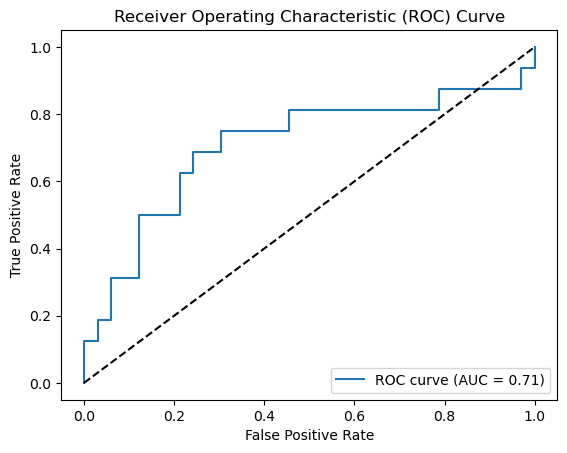

In [9]:
SVM_Classifier_Log = SVM(df[0]["df0"],df[3],df[1]["df0"],df[4])

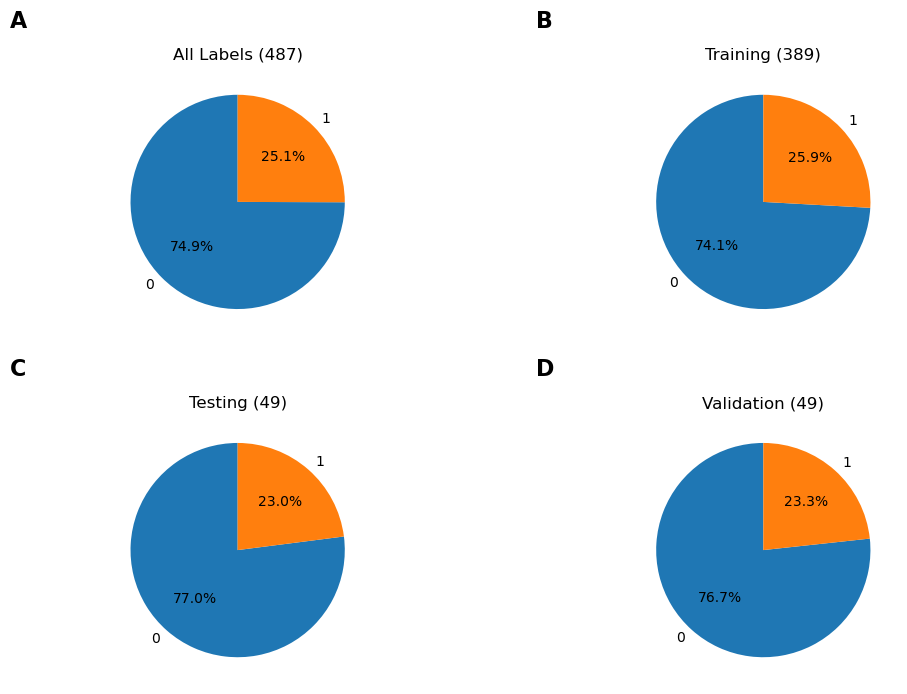

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataframes
df1 = pd.DataFrame(labels)
df2 = pd.DataFrame(df[3])
df3 = pd.DataFrame(df[4])
df4 = pd.DataFrame(df[5])

dataframes = [df1, df2, df3, df4]
names = ['All Labels (487)', 'Training (389)', 'Testing (49)', 'Validation (49)']

# Calculate proportions and plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, df_1 in enumerate(dataframes):
    row = i // 2
    col = i % 2
    
    distribution = df_1['label'].value_counts(normalize=True) * 100
    
    axs[row, col].pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=90)
    axs[row, col].set_title(names[i])
    axs[row, col].text(-0.35, 1.15, chr(65+i), transform=axs[row, col].transAxes, fontsize=16, fontweight='bold')  # Add label A, B, C, D
    

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()



#### Combined plots

pred step 1 complete
pred step 2 complete
Mean AUC over folds: 0.7920593607305936
Standard Deviation of AUC: 0.07643382582604351


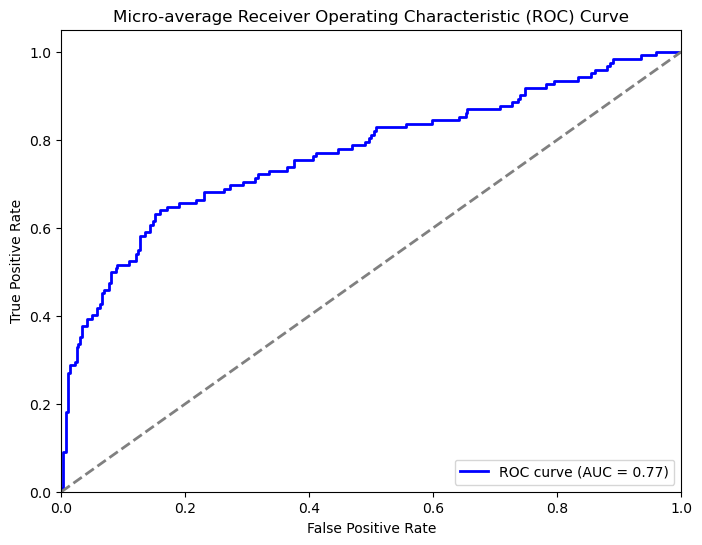

In [9]:
def SVM(X_train, y_train):
    svm_classifier = svm.SVC(probability=True, kernel = "rbf")
    #cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5)
    #mean_accuracy = cv_scores.mean()
    #std_accuracy = cv_scores.std()
    #print("Mean Cross-Validated Accuracy:", mean_accuracy)
    #print("Standard Deviation of Accuracy:", std_accuracy)

    y_pred_probs = cross_val_predict(svm_classifier, X_train, y_train, cv=5, method='predict_proba')
    print("pred step 1 complete")
    y_pred = cross_val_predict(svm_classifier, X_train, y_train, cv=5)
    
    print("pred step 2 complete")
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(svm_classifier, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(svm_classifier, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return svm_classifier, fpr, tpr, roc_auc, mean_score, std_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
SVM_Classifier_Rank = SVM(Log_targets,labels["label"])

In [11]:
import pickle

with open('HPA_set1_SVM_40k.pkl', 'wb') as file:
    pickle.dump(SVM_Classifier_Rank, file)

In [12]:
import pickle

with open('HPA_set1_SVM_40k.pkl', 'rb') as file:
    loaded_data = pickle.load(file)


In [14]:
SVM_Classifier_Rank

(SVC(probability=True),
 array([0.        , 0.        , 0.00273973, 0.00273973, 0.00821918,
        0.00821918, 0.0109589 , 0.0109589 , 0.01369863, 0.01369863,
        0.02191781, 0.02191781, 0.02465753, 0.02465753, 0.02739726,
        0.02739726, 0.03013699, 0.03013699, 0.03287671, 0.03287671,
        0.04109589, 0.04109589, 0.04931507, 0.04931507, 0.05753425,
        0.05753425, 0.0630137 , 0.0630137 , 0.06575342, 0.06575342,
        0.06849315, 0.06849315, 0.07671233, 0.07671233, 0.07945205,
        0.07945205, 0.08767123, 0.08767123, 0.09041096, 0.09041096,
        0.10958904, 0.10958904, 0.12054795, 0.12054795, 0.12328767,
        0.12328767, 0.1260274 , 0.1260274 , 0.13424658, 0.13424658,
        0.14246575, 0.14246575, 0.14794521, 0.14794521, 0.15068493,
        0.15068493, 0.15890411, 0.15890411, 0.16986301, 0.16986301,
        0.1890411 , 0.1890411 , 0.21643836, 0.21643836, 0.23013699,
        0.23013699, 0.2630137 , 0.2630137 , 0.27123288, 0.27123288,
        0.29315068, 0.29

Mean Cross-Validated Accuracy: 0.8214811697875026
Standard Deviation of Accuracy: 0.0286621966656011
Mean AUC over folds: 0.7220958904109589
Standard Deviation of AUC: 0.05231439792514512


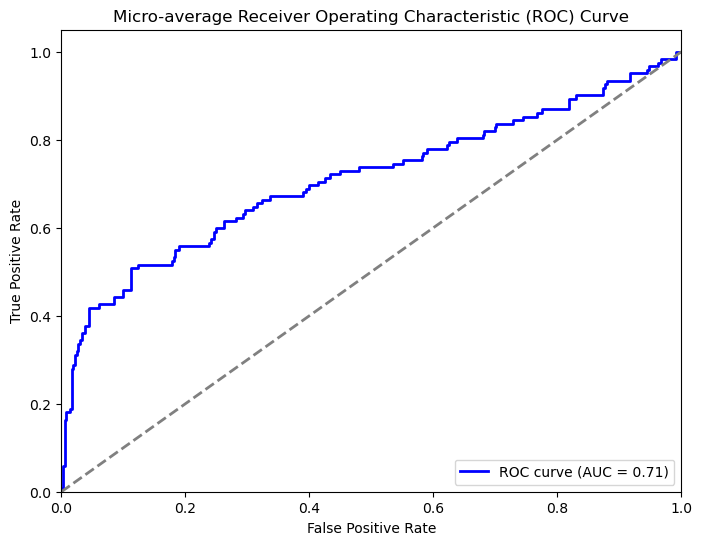

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
SVM_Classifier_Rank = SVM(Rank_targets,labels["label"])

In [4]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict

Random_Forest_Log = RF(Log_targets,labels["label"])
Random_Forest_Row = RF(Row_targets,labels["label"])
Random_Forest_Rank = RF(Rank_targets,labels["label"])
#Random_Forest_RawCounts = RF(Raw_targets,labels["label"])

SVM_Classifier_Log = SVM(Log_targets,labels["label"])
SVM_Classifier_Row = SVM(Row_targets,labels["label"])
SVM_Classifier_Rank = SVM(Rank_targets,labels["label"])
#SVM_Classifier_RawCounts = SVM(Raw_targets,labels["label"])

Logistic_Regression_Log = logistic_regression(Log_targets,labels["label"])
Logistic_Regression_Row = logistic_regression(Row_targets,labels["label"])
Logistic_Regression_Rank = logistic_regression(Rank_targets,labels["label"])
#Logistic_Regression_RawCounts = logistic_regression(Raw_targets,labels["label"])

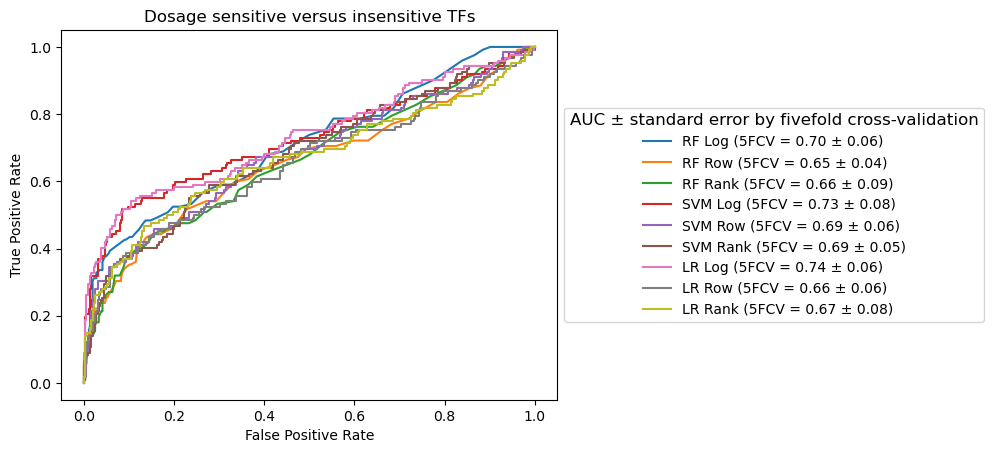

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# Example data for three classifiers
fpr1 = Random_Forest_Log[1]
tpr1 = Random_Forest_Log[2]
auc1 = Random_Forest_Log[3]
mean_acc1 = Random_Forest_Log[4]
std_acc1 = Random_Forest_Log[5]

fpr2 = Random_Forest_Row[1]
tpr2 = Random_Forest_Row[2]
auc2 = Random_Forest_Row[3]
mean_acc2 = Random_Forest_Row[4]
std_acc2 = Random_Forest_Row[5]

fpr3 = Random_Forest_Rank[1]
tpr3 = Random_Forest_Rank[2]
auc3 = Random_Forest_Rank[3]
mean_acc3 = Random_Forest_Rank[4]
std_acc3 = Random_Forest_Rank[5]

fpr4 = SVM_Classifier_Log[1]
tpr4 = SVM_Classifier_Log[2]
auc4 = SVM_Classifier_Log[3]
mean_acc4 = SVM_Classifier_Log[4]
std_acc4 = SVM_Classifier_Log[5]

fpr5 = SVM_Classifier_Row[1]
tpr5 = SVM_Classifier_Row[2]
auc5 = SVM_Classifier_Row[3]
mean_acc5 = SVM_Classifier_Row[4]
std_acc5 = SVM_Classifier_Row[5]

fpr6 = SVM_Classifier_Rank[1]
tpr6 = SVM_Classifier_Rank[2]
auc6 = SVM_Classifier_Rank[3]
mean_acc6 = SVM_Classifier_Rank[4]
std_acc6 = SVM_Classifier_Rank[5]

fpr7 = Logistic_Regression_Log[1]
tpr7 = Logistic_Regression_Log[2]
auc7 = Logistic_Regression_Log[3]
mean_acc7 = Logistic_Regression_Log[4]
std_acc7 = Logistic_Regression_Log[5]

fpr8 = Logistic_Regression_Row[1]
tpr8 = Logistic_Regression_Row[2]
auc8 = Logistic_Regression_Row[3]
mean_acc8 = Logistic_Regression_Row[4]
std_acc8 = Logistic_Regression_Row[5]

fpr9 = Logistic_Regression_Rank[1]
tpr9 = Logistic_Regression_Rank[2]
auc9 = Logistic_Regression_Rank[3]
mean_acc9 = Logistic_Regression_Rank[4]
std_acc9 = Logistic_Regression_Rank[5]

# Example data for RawCounts classifiers
#fpr10 = Random_Forest_RawCounts[1]
#tpr10 = Random_Forest_RawCounts[2]
#auc10 = Random_Forest_RawCounts[3]
#mean_acc10 = Random_Forest_RawCounts[4]
#std_acc10 = Random_Forest_RawCounts[5]

#fpr11 = SVM_Classifier_RawCounts[1]
#tpr11 = SVM_Classifier_RawCounts[2]
#auc11 = SVM_Classifier_RawCounts[3]
#mean_acc11 = SVM_Classifier_RawCounts[4]
#std_acc11 = SVM_Classifier_RawCounts[5]

#fpr12 = Logistic_Regression_RawCounts[1]
#tpr12 = Logistic_Regression_RawCounts[2]
#auc12 = Logistic_Regression_RawCounts[3]
#mean_acc12 = Logistic_Regression_RawCounts[4]
#std_acc12 = Logistic_Regression_RawCounts[5]

# Create a new figure and plot the ROC curves
plt.figure()

plt.plot(fpr1, tpr1, label='RF Log (5FCV = %0.2f ± %0.2f)' % (mean_acc1, std_acc1))
plt.plot(fpr2, tpr2, label='RF Row (5FCV = %0.2f ± %0.2f)' % (mean_acc2, std_acc2))
plt.plot(fpr3, tpr3, label='RF Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc3, std_acc3))
plt.plot(fpr4, tpr4, label='SVM Log (5FCV = %0.2f ± %0.2f)' % (mean_acc4, std_acc4))
plt.plot(fpr5, tpr5, label='SVM Row (5FCV = %0.2f ± %0.2f)' % (mean_acc5, std_acc5))
plt.plot(fpr6, tpr6, label='SVM Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc6, std_acc6))
plt.plot(fpr7, tpr7, label='LR Log (5FCV = %0.2f ± %0.2f)' % (mean_acc7, std_acc7))
plt.plot(fpr8, tpr8, label='LR Row (5FCV = %0.2f ± %0.2f)' % (mean_acc8, std_acc8))
plt.plot(fpr9, tpr9, label='LR Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc9, std_acc9))
#plt.plot(fpr10, tpr10, label='RF RawCounts (5FCV = %0.2f ± %0.2f)' % (mean_acc10, std_acc10))
#plt.plot(fpr11, tpr11, label='SVM RawCounts (5FCV = %0.2f ± %0.2f)' % (mean_acc11, std_acc11))
#plt.plot(fpr12, tpr12, label='LR RawCounts (5FCV = %0.2f ± %0.2f)' % (mean_acc12, std_acc12))

# Set plot title and labels
plt.title('Dosage sensitive versus insensitive TFs')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add legend on the right side with a title
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='AUC ± standard error by fivefold cross-validation')

                    # Set the title font size
plt.setp(legend.get_title(), fontsize='large')

# Save the plot to a file
plt.savefig('roc_plot.png')

# Show the plot
plt.show()

#### Geneformer

In [ ]:
#........................
random_indexes = np.random.choice(len(input_ids), size=sample_size, replace=False)
>>> random_indexes
array([ 8774377,  4175258, 24375969, ..., 18077919, 12983196, 26608444])
random_inputs = input_ids[random_indexes]
random_lengths = lengths[random_indexes]
random_cells = np.asarray(df)[random_indexes]

# Assuming you have the following variables:
# - random_inputs: A list of lists containing ranked IDs per cell
# - random_cells: An array of cell IDs corresponding to the ranked IDs

# Get unique gene IDs from the token dictionary values
unique_gene_ids = list(token_dictionary.values())

# Create an empty matrix with rows as unique gene IDs and columns as cells
matrix = np.zeros((len(unique_gene_ids), len(random_cells)))

# Iterate over the cells and their corresponding ranked IDs
for cell_index, ranked_ids in enumerate(random_inputs):
    for rank, gene_id in enumerate(ranked_ids):
        # Find the index of the gene ID in the unique gene IDs list
        gene_index = unique_gene_ids.index(gene_id)
        # Assign the rank value to the matrix at the corresponding gene and cell indices
        matrix[gene_index, cell_index] = rank + 1  # Add 1 to the rank to start from 1 instead of 0

# Now, the matrix contains the ranking of genes for each individual cell

In [10]:
%%capture
!pip install seaborn
!pip install statsmodels
!git clone https://huggingface.co/ctheodoris/Geneformer; cd Geneformer; pip install .
!pip install transformers==4.28.0
!pip install --upgrade accelerate -U
!pip install datasets
!pip install torch

# imports
import datetime
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_from_disk
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import StratifiedKFold
import torch
from transformers import BertForTokenClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments
from tqdm.notebook import tqdm

from geneformer import DataCollatorForGeneClassification
from geneformer.pretrainer import token_dictionary




Load Gene Attribute Information


In [11]:
# table of corresponding Ensembl IDs, gene names, and gene types (e.g. coding, miRNA, etc.)
gene_info = pd.read_csv("gene_info_table.csv", index_col=0)

# create dictionaries for corresponding attributes
gene_id_type_dict = dict(zip(gene_info["ensembl_id"],gene_info["gene_type"]))
gene_name_id_dict = dict(zip(gene_info["gene_name"],gene_info["ensembl_id"]))
gene_id_name_dict = {v: k for k,v in gene_name_id_dict.items()}


Load Training Data and Class Labels


In [14]:
# function for preparing targets and labels
def prep_inputs(genegroup1, genegroup2, id_type):
    if id_type == "gene_name":
        targets1 = [gene_name_id_dict[gene] for gene in genegroup1 if gene_name_id_dict.get(gene) in token_dictionary]
        targets2 = [gene_name_id_dict[gene] for gene in genegroup2 if gene_name_id_dict.get(gene) in token_dictionary]
    elif id_type == "ensembl_id":
        targets1 = [gene for gene in genegroup1 if gene in token_dictionary]
        targets2 = [gene for gene in genegroup2 if gene in token_dictionary]
            
    targets1_id = [token_dictionary[gene] for gene in targets1]
    targets2_id = [token_dictionary[gene] for gene in targets2]
    
    targets = np.array(targets1_id + targets2_id)
    labels = np.array([0]*len(targets1_id) + [1]*len(targets2_id))
    nsplits = min(5, min(len(targets1_id), len(targets2_id))-1)
    assert nsplits > 2
    print(f"# targets1: {len(targets1_id)}\n# targets2: {len(targets2_id)}\n# splits: {nsplits}")
    return targets, labels, nsplits

In [15]:
# preparing targets and labels for dosage sensitive vs insensitive TFs
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
targets, labels, nsplits = prep_inputs(sensitive, insensitive, "ensembl_id")

# targets1: 122
# targets2: 368
# splits: 5


In [ ]:
# load training dataset
train_dataset=load_from_disk("gene_train_data.dataset")
shuffled_train_dataset = train_dataset.shuffle(seed=42)
subsampled_train_dataset = shuffled_train_dataset.select([i for i in range(50_000)])

In [131]:
# Read the CSV file into a DataFrame
df = pd.read_csv('10kCells.csv')

# Save the DataFrame as a dataset file
df.to_pickle('10kCells.dataset')

In [134]:
import pandas as pd

# Load the dataset from the CSV file
train_dataset = pd.read_csv('10kCells.csv')

# Perform your desired operations on the dataset
shuffled_train_dataset = train_dataset.sample(frac=1, random_state=42)
subsampled_train_dataset = shuffled_train_dataset.head(10000) # 10K subsampled from 10K dataset



In [135]:
subsampled_train_dataset

,Brain,Adipose,Brain.1,Endometrium,Endometrium.1,Endometrium.2,Kidney,Skin,Brain.2,Skeletal,...,Endometrium.1206,Brain.1394,Liver.156,Breast.808,Endometrium.1207,Spleen.74,Eye.330,Skin.296,PBMC.102,Endometrium.1208
8900,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2812,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1606,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
10599,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10873,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
6083,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9305,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training hyperparameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 4
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 24
# batch size for training and eval
geneformer_batch_size = 12
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 1
# optimizer
optimizer = "adamw"

# set training arguments
subsample_size = 10_000
training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "evaluation_strategy": "no",
    "save_strategy": "epoch",
    "logging_steps": 100,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
}

In [142]:
# define output directory path
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
training_output_dir = f"{datestamp}_geneformer_GeneClassifier_dosageTF_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_n{subsample_size}_F{freeze_layers}/"

# ensure not overwriting previously saved model
ksplit_model_test = os.path.join(training_output_dir, "ksplit0/models/pytorch_model.bin")
if os.path.isfile(ksplit_model_test) == True:
    raise Exception("Model already saved to this directory.")

# make output directory
subprocess.call(f'mkdir {training_output_dir}', shell=True)

0

In [145]:
# cross-validate gene classifier
all_roc_auc, roc_auc, roc_auc_sd, mean_fpr, mean_tpr, confusion, label_dicts \
    = cross_validate(subsampled_train_dataset, targets, labels, nsplits, subsample_size, training_args, freeze_layers, training_output_dir, 1)

0it [00:00, ?it/s]

****** Crossval split: 0/4 ******

Filtering training data


TypeError: NDFrame.filter() got an unexpected keyword argument 'num_proc'

#### scBERT

In [5]:
%%capture
!pip install transformers
!pip install pytorch
!pip install torch

In [8]:
from transformers import AutoTokenizer

# Load the scBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Example count data DataFrame
count_data = Log_targets

# Get the TF identifiers from the index
tf_identifiers = count_data.index.tolist()

# Tokenize the TF identifiers
tokenized_data = tokenizer.batch_encode_plus(
    tf_identifiers,
    padding=True,
    truncation=True,
    max_length=512,  # Adjust the maximum sequence length as per your requirements
    return_tensors="pt"  # Return PyTorch tensors
)

# Get the tokenized TF sequences
tokenized_sequences = tokenized_data["input_ids"]

# Print the tokenized sequences
print(tokenized_sequences)


tensor([[  102,  2658, 30123,  ...,  3317,   103,     0],
        [  102,  2658, 30123,  ...,  5688,   103,     0],
        [  102,  2658, 30123,  ...,  3189,   103,     0],
        ...,
        [  102,  2658, 30123,  ...,  2642, 30138,   103],
        [  102,  2658, 30123,  ...,  5576, 30141,   103],
        [  102,  2658, 30123,  ...,  1933, 30132,   103]])


In [9]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(
    tokenized_sequences, labels["label"], test_size=0.2)

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16  # Adjust the batch size as per your requirements

# Create TensorDatasets
train_dataset = TensorDataset(train_sequences, torch.tensor(train_labels))
val_dataset = TensorDataset(val_sequences, torch.tensor(val_labels))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [12]:
from transformers import AutoModelForSequenceClassification, AdamW
import torch.nn as nn

# Load the scBERT base model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=2)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Fine-tuning loop
num_epochs = 10  # Adjust the number of epochs as per your requirements

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch
        
        optimizer.zero_grad()
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, labels = batch
            
            outputs = model(input_ids, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / val_total
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Epoch 1/10: Train Loss: 0.5537 | Val Loss: 0.5305 | Val Accuracy: 0.7245
Epoch 2/10: Train Loss: 0.5614 | Val Loss: 0.5182 | Val Accuracy: 0.7245
Epoch 3/10: Train Loss: 0.5455 | Val Loss: 0.5002 | Val Accuracy: 0.7245
Epoch 4/10: Train Loss: 0.5175 | Val Loss: 0.4824 | Val Accuracy: 0.7143
Epoch 5/10: Train Loss: 0.4623 | Val Loss: 0.5071 | Val Accuracy: 0.6837
Epoch 6/10: Train Loss: 0.4348 | Val Loss: 0.5393 | Val Accuracy: 0.7143
Epoch 7/10: Train Loss: 0.4264 | Val Loss: 0.5019 | Val Accuracy: 0.7245
Epoch 8/10: Train Loss: 0.4257 | Val Loss: 0.5259 | Val Accuracy: 0.7143
Epoch 9/10: Train Loss: 0.3859 | Val Loss: 0.5363 | Val Accuracy: 0.6939
Epoch 10/10: Train Loss: 0.3410 | Val Loss: 0.5981 | Val Accuracy: 0.7041


In [13]:
# Tokenize new TF sequences
new_tf_sequences = Log_targets

tokenized_new_sequences = tokenizer.batch_encode_plus(
    new_tf_sequences,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Get the tokenized sequences
input_ids = tokenized_new_sequences["input_ids"]

# Make predictions
model.eval()
input_ids = input_ids.to(device)
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)

# Print predicted labels
print(predicted_labels)


TypeError: batch_text_or_text_pairs has to be a list or a tuple (got <class 'pandas.core.frame.DataFrame'>)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the true labels in 'true_labels' and predicted labels in 'predicted_labels'

# Compute the predicted probabilities for the positive class (dosage sensitive)
predicted_probabilities = model.predict_proba(input_ids)
dosage_sensitive_probs = predicted_probabilities[:, 1]  # Assuming the positive class is at index 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, dosage_sensitive_probs)

# Compute the AUC score
auc_score = roc_auc_score(true_labels, dosage_sensitive_probs)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### scGPT

In [ ]:
%%capture
!pip install transformers torch torchvision

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have your count data stored in the 'count_data' variable

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize the count data
tokenized_data = tokenizer.batch_encode_plus(
    count_data,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Get the tokenized sequences
input_ids = tokenized_data["input_ids"]

# Assuming you have your labels stored in the 'labels' variable

# Convert the labels to tensors
labels = torch.tensor(labels)

# Create a TensorDataset
dataset = TensorDataset(input_ids, labels)

# Define the batch size and create a DataLoader
batch_size = 8  # Adjust the batch size according to your memory capacity and data size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Assuming you want to classify into two classes: dosage sensitive and insensitive

# Load the base GPT2 model
base_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Modify the model head for classification
num_labels = 2
model = nn.Sequential(
    base_model,
    nn.Linear(base_model.config.hidden_size, num_labels)
)

In [ ]:
# Define the training parameters
num_epochs = 10
learning_rate = 1e-4

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch_input_ids, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        logits = model(batch_input_ids)[0]
        loss = criterion(logits.view(-1, num_labels), batch_labels.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


In [ ]:
# Assuming you want to save the model to a file named 'fine_tuned_model.pth'

torch.save(model.state_dict(), "fine_tuned_model.pth")


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Tokenize new TF sequences
new_tf_sequences = Log_targets

tokenized_new_sequences = tokenizer.batch_encode_plus(
    new_tf_sequences,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Get the tokenized sequences
input_ids = tokenized_new_sequences["input_ids"]

# Convert to DataLoader
dataset = TensorDataset(input_ids)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Make predictions
model.eval()
input_ids = input_ids.to(device)
with torch.no_grad():
    all_predicted_labels = []
    for batch in dataloader:
        batch = batch[0].to(device)
        outputs = model.generate(batch, max_length=2, num_return_sequences=1)
        predicted_label = outputs[:, -1].cpu().tolist()  # Assuming the predicted label is the last token
        all_predicted_labels.extend(predicted_label)

# Compute the predicted probabilities for the positive class (dosage sensitive)
predicted_probabilities = torch.tensor(all_predicted_labels)
dosage_sensitive_probs = predicted_probabilities  # Assuming the predicted probabilities are already in the range [0, 1]

# Assuming you have the true labels in 'true_labels'
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, dosage_sensitive_probs)

# Compute the AUC score
auc_score = roc_auc_score(true_labels, dosage_sensitive_probs)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### Random Forest

Log Normalized Classifier

Mean Cross-Validated Accuracy: 0.7378288378288379
Standard Deviation of Accuracy: 0.018629754149615926
Accuracy: 0.7551020408163265
Precision: 1.0
AUC: 0.7040598290598291


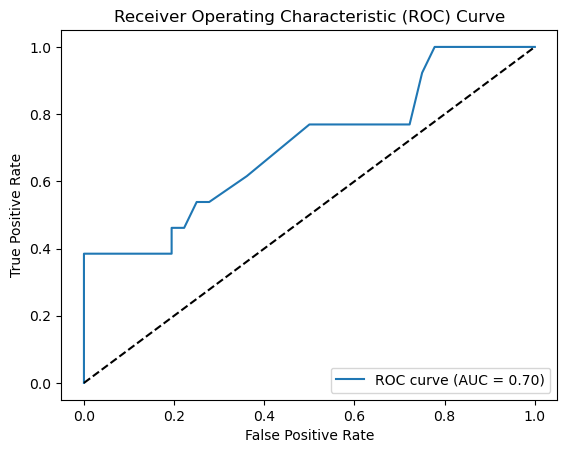

In [65]:
Random_Forest_Log = RF(df[0]["df0"],df[3],df[1]["df0"],df[4])

Row Normalized Classifier

Mean Cross-Validated Accuracy: 0.742957042957043
Standard Deviation of Accuracy: 0.007150130544869992
Accuracy: 0.7551020408163265
Precision: 1.0
AUC: 0.47435897435897445


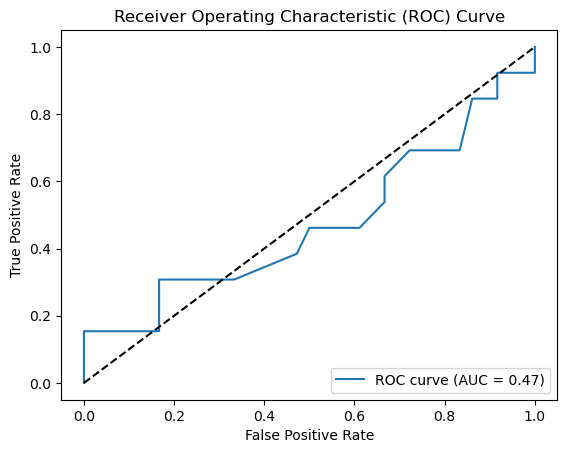

In [66]:
Random_Forest_Row = RF(df[0]["df1"],df[3],df[1]["df1"],df[4])

Rank Normalized Classifier

Mean Cross-Validated Accuracy: 0.7352647352647353
Standard Deviation of Accuracy: 0.012107207038321363
Accuracy: 0.7142857142857143
Precision: 0.0
AUC: 0.5972222222222223


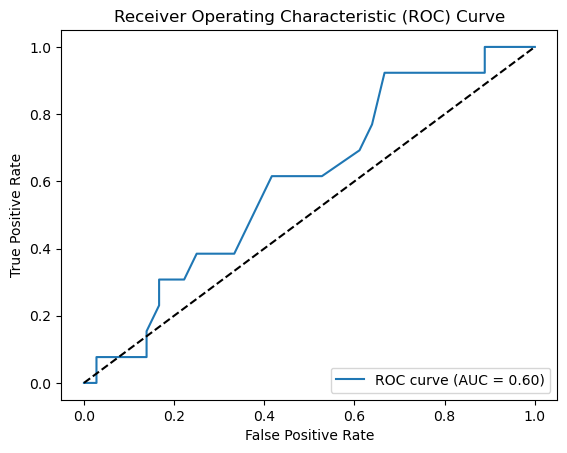

In [67]:
Random_Forest_Rank = RF(df[0]["df2"],df[3],df[1]["df2"],df[4])

#### SVM

Log Normalized Classifier

Mean Cross-Validated Accuracy: 0.8200799200799201
Standard Deviation of Accuracy: 0.011006454434737717
Accuracy: 0.7755102040816326
Precision: 0.5
AUC: 0.7272727272727273


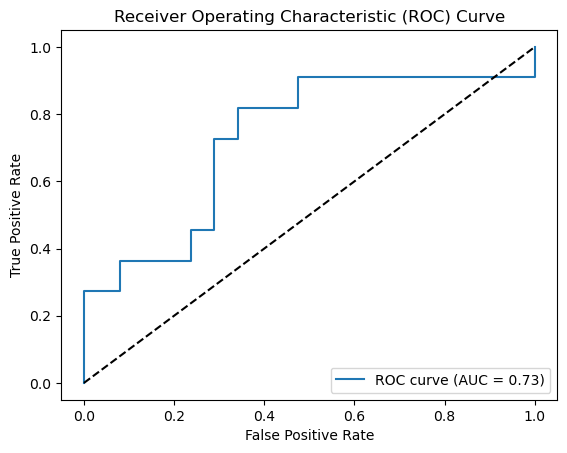

In [64]:
SVM_Classifier_Log = SVM(df[0]["df0"],df[3],df[1]["df0"],df[4])

In [65]:
Classifier(SVM_Classifier_Log,df[2]["df1"],df[5])

AttributeError: 'tuple' object has no attribute 'predict'

Row Normalized Classifier

Mean Cross-Validated Accuracy: 0.7481185481185482
Standard Deviation of Accuracy: 0.012156747156737919
Accuracy: 0.7551020408163265
Precision: 1.0
AUC: 0.5512820512820513


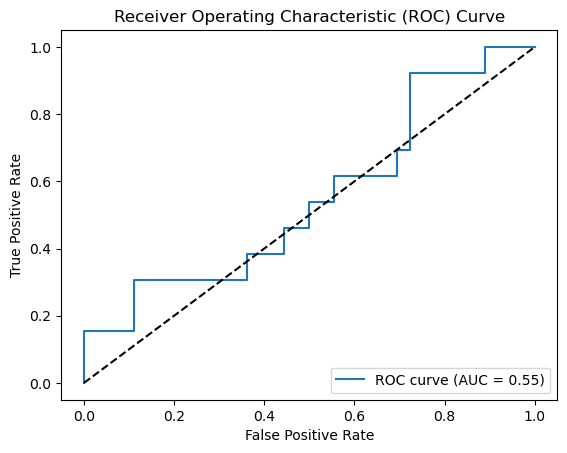

In [82]:
SVM_Classifier_Row = SVM(df[0]["df1"],df[3],df[1]["df1"],df[4])

Accuracy: 0.7755102040816326
Precision: 0.0
AUC: 0.6674641148325359


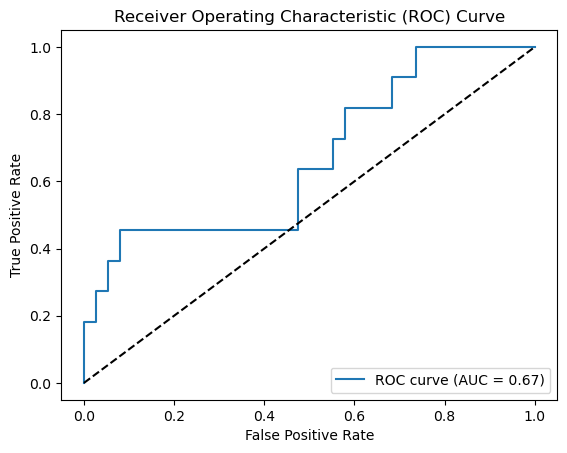

In [31]:
Classifier(SVM_Classifier_Row,df[2]["df2"],df[5])

Rank Normalized Classifier

Mean Cross-Validated Accuracy: 0.7455211455211456
Standard Deviation of Accuracy: 0.0038628038628038654
Accuracy: 0.7551020408163265
Precision: 1.0
AUC: 0.6111111111111112


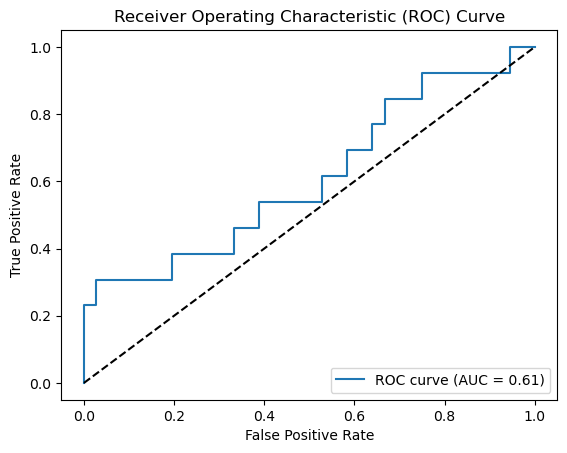

In [83]:
SVM_Classifier_Rank = SVM(df[0]["df2"],df[3],df[1]["df2"],df[4])

Accuracy: 0.8571428571428571
Precision: 0.8
AUC: 0.6410256410256411


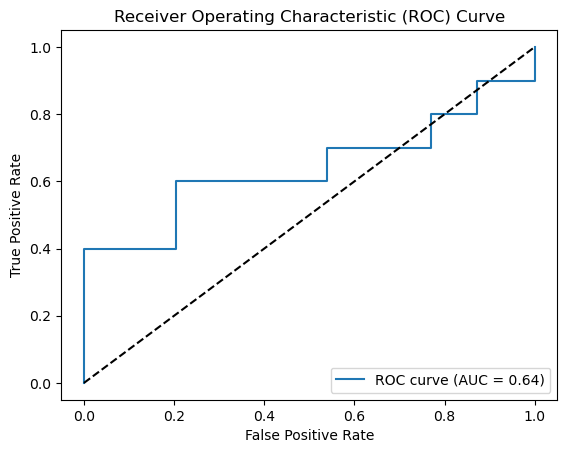

In [97]:
Classifier(SVM_Classifier_Rank,df[2]["df3"],df[5])

#### LR

Log Normalized Classifier

Mean Cross-Validated Accuracy: 0.7634698634698636
Standard Deviation of Accuracy: 0.037834553511908245
Accuracy: 0.7755102040816326
Precision: 0.6666666666666666
AUC: 0.6474358974358975


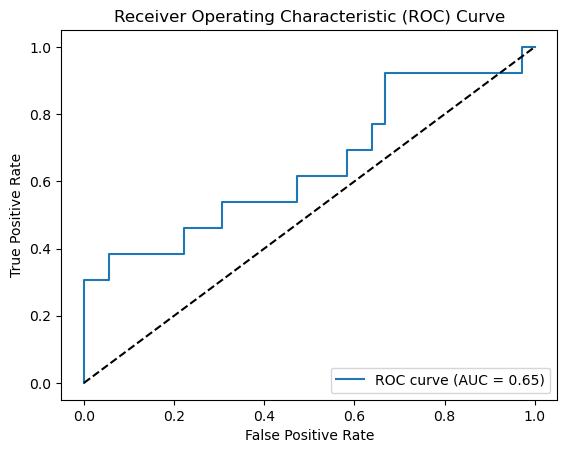

In [89]:
Logistic_Regression_Log = logistic_regression(df[0]["df0"],df[3],df[1]["df0"],df[4])

Row Normalized Classifier

Mean Cross-Validated Accuracy: 0.7403263403263404
Standard Deviation of Accuracy: 0.032074795359034854
Accuracy: 0.6938775510204082
Precision: 0.3333333333333333
AUC: 0.6004273504273505


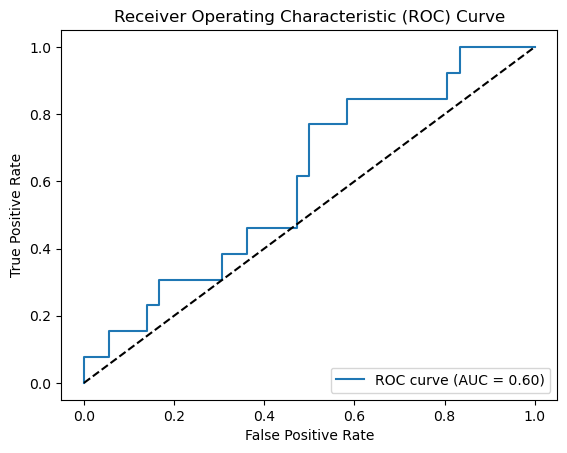

In [90]:
Logistic_Regression_Row = logistic_regression(df[0]["df1"],df[3],df[1]["df1"],df[4])

Rank Normalized Classifier

Mean Cross-Validated Accuracy: 0.6915084915084915
Standard Deviation of Accuracy: 0.021512285439171414
Accuracy: 0.6326530612244898
Precision: 0.14285714285714285
AUC: 0.49786324786324787


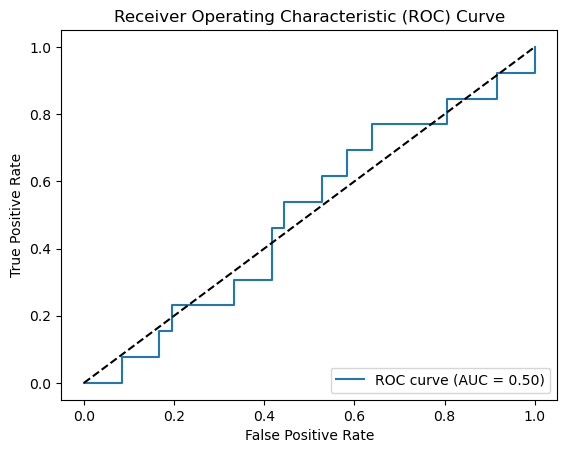

In [91]:
Logistic_Regression_Rank = logistic_regression(df[0]["df2"],df[3],df[1]["df2"],df[4])